# Goal: Assess whether the number of Units per zip code is a good predictor of citibike trips originating from that zip code.

In [1]:
import numpy as np
from numpy import random
import pandas as pd
import pylab as pl
%pylab inline

import scipy
from scipy import stats

import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [2]:
import json
import urllib2

In [3]:
# Load station id json file
url = 'http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json'
request = urllib2.urlopen(url)
sid_to_zip = json.load(request)

In [4]:
# Load Citibike Data of two months
df_jan = pd.read_csv('201501-citibike-tripdata.csv')
df_aug = pd.read_csv('201508-citibike-tripdata.csv')

In [5]:
my_rides_dataframe = pd.concat([df_jan,df_aug])
my_rides_dataframe.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [6]:
# Load the MapPluto of Manhattan
import geopandas as gp
my_building_dataframe = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")

In [8]:
my_building_dataframe.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [11]:
# Create the column of 'zipcode'
my_rides_dataframe['ZipCode'] = [sid_to_zip[str(i)] for i in my_rides_dataframe['start station id']]

In [12]:
# Count trips by zip code
myarray1 = (my_rides_dataframe['start station id'].groupby(my_rides_dataframe['ZipCode']).count())

In [13]:
# Sum Residential units by zip code
myarray2 = (my_building_dataframe['UnitsRes'].groupby(my_building_dataframe['ZipCode']).sum())

In [14]:
mynewdf = pd.concat([myarray1,myarray2], axis=1)

In [15]:
mynewdf.columns = ['Number of Trips', 'Residential Units']

In [16]:
mynewdf.count()

Number of Trips      38
Residential Units    54
dtype: int64

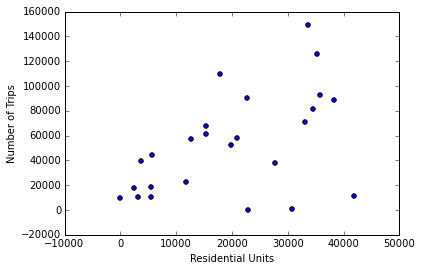

In [17]:
# Test scatterplot
mynewdf.plot(kind='scatter',x='Residential Units',y='Number of Trips')

In [18]:
import statsmodels.api as sm
# Line fit
X = mynewdf['Residential Units']
Y = mynewdf['Number of Trips']
model1 = sm.OLS(Y, sm.add_constant(X), missing='drop').fit()  
print model1.params[1], model1.params[0]

1.55681226397 22318.6979278


In [19]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Number of Trips   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     7.569
Date:                Wed, 21 Oct 2015   Prob (F-statistic):             0.0114
Time:                        22:07:16   Log-Likelihood:                -296.89
No. Observations:                  25   AIC:                             597.8
Df Residuals:                      23   BIC:                             600.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              2.232e+04   1.34e+04      1.669      0.109     -5340.011     5e+04
Residential Units     1.5568      0.566      2.751      0.011         0.386     2.727
==============================================================================
Omnibus:                        1.003   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.234
Skew:                          -0.189   Prob(JB):                        0.890
Kurtosis:                       3.285   Cond. No.                     4.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

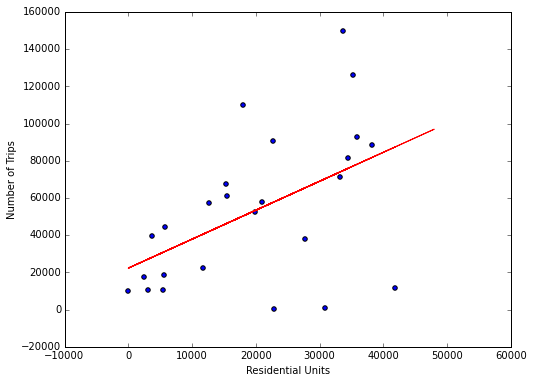

In [48]:
# Plot line fit 
pl.figure(figsize=(8, 6))
pl.scatter(X,Y)
pl.xlabel('Residential Units')
pl.ylabel('Number of Trips')
pl.plot(X,X*model1.params[1]+model1.params[0],color='red')
pl.legend()

# The first degree linear model seems to be able to fit the points but there are outliers.

In [22]:
# Clean the nan value data 
df_notnan = mynewdf.dropna(axis=0)

In [23]:
# 2 degree linear fit
curvemodel = smf.ols(formula = "y ~ x + I((x)) + I((x)**2) ", 
        data={'x':df_notnan['Residential Units'],'y': df_notnan['Number of Trips']})
model2 = curvemodel.fit()

In [24]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     4.471
Date:                Wed, 21 Oct 2015   Prob (F-statistic):             0.0235
Time:                        22:07:52   Log-Likelihood:                -296.18
No. Observations:                  25   AIC:                             598.4
Df Residuals:                      22   BIC:                             602.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7564.4328   1.86e+04      0.406      0.688      -3.1e+04  4.62e+04
x               2.0036      1.117      1.793      0.087        -0.313     4.320
I((x))          2.0028      1.119      1.790      0.087        -0.317     4.323
I((x) ** 2) -6.067e-05   5.36e-05     -1.132      0.270        -0.000  5.05e-05
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.269
Skew:                          -0.196   Prob(JB):                        0.874
Kurtosis:                       3.324   Cond. No.                     7.20e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

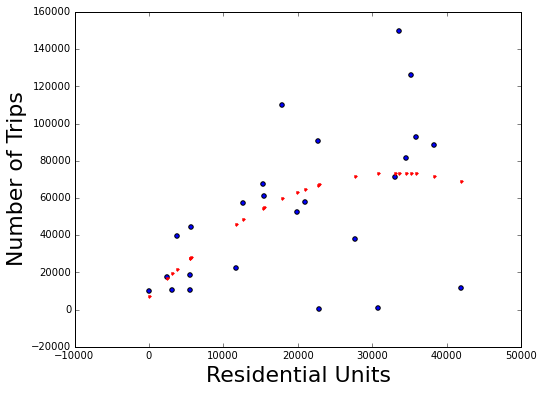

In [25]:
pl.figure(figsize=(8, 6))
pl.scatter(df_notnan['Residential Units'], df_notnan['Number of Trips'])
pl.xlabel("Residential Units", fontsize=22)
pl.ylabel("Number of Trips", fontsize=22)
plot(df_notnan['Residential Units'], model2.predict(),'k.',c='r')

## The 2 degree model seems not to fit the points well.

In [26]:
Likelihood_1 = model1.llf
Likelihood_2 = model2.llf
lr = -2*(Likelihood_1 - Likelihood_2)
print lr

1.41524749551


## Test Result
DOF = 1
Null Hypothesis: the line fit is better then 2 degree polynomial fit
The critical value for chi2 with 1 degree of freedom at alpha = 0.05 is 3.84 so that the lr value is not bigger than the critical value.
Therefore, we cannot reject the null hypothesis. The line fit is better.

In [27]:
# Remove the extreme values
mynewdf_v2 = df_notnan[(df_notnan['Residential Units']>0)&(df_notnan['Residential Units']<40000)&(df_notnan['Number of Trips']>3000)]                                     

In [28]:
X2 = mynewdf_v2['Residential Units']
Y2 = mynewdf_v2['Number of Trips']

In [29]:
# Line fit after removing the leverage points
model1_v2 = sm.OLS(Y2, sm.add_constant(X2), missing='drop').fit()  
print model1_v2.params[1], model1_v2.params[0]

2.37478208616 16979.3905512


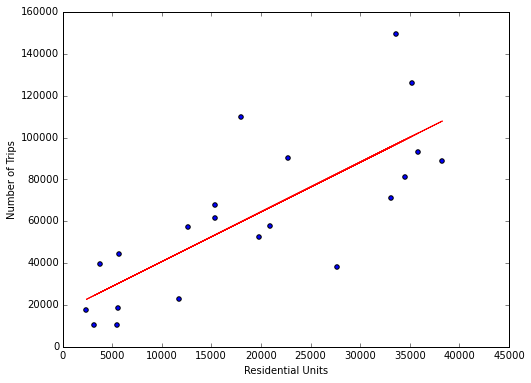

In [47]:
pl.figure(figsize=(8, 6))
pl.scatter(X2,Y2)
pl.xlabel('Residential Units')
pl.ylabel('Number of Trips')
pl.plot(X2,X2*model1_v2.params[1]+model1_v2.params[0],color='red')
pl.legend()

In [31]:
# 2 degree linear fit after removing the leverage points
model2_v2 = smf.ols(formula = "y ~ x + I((x)) + I((x)**2) ", 
        data={'x':X2,'y': Y2}).fit()

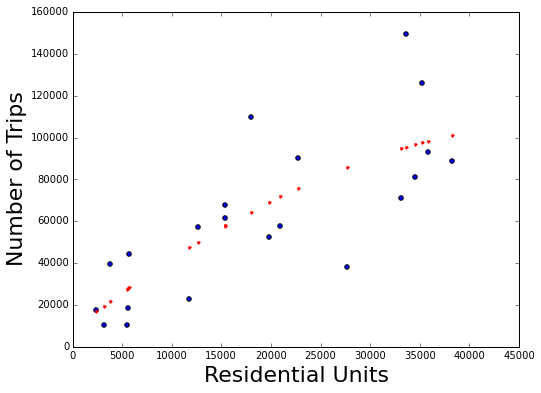

In [32]:
pl.figure(figsize=(8, 6))
pl.scatter(X2, Y2)
pl.xlabel("Residential Units", fontsize=22)
pl.ylabel("Number of Trips", fontsize=22)
plot(X2, model2_v2.predict(),'k.',c='r')

In [33]:
Likelihood_1_v2 = model1_v2.llf
Likelihood_2_v2 = model2_v2.llf
lr_v2 = -2*(Likelihood_1_v2 - Likelihood_2_v2)
print lr

1.41524749551


## Result
After removing the outlier points, the line fit is still better than the 2 degree model fit given the lr value is not larger than the critical value 3.84.

# Some Findings
From the 1 degree linear model, we can see that the more residential units per zip code, the more number of trips per zip code. As shown in the model summary below, the p-value of the coefficient is so low that it is in high confidence to say that the residential units' number and the trips' number are correlated.

In [34]:
model1_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Number of Trips   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     27.84
Date:                Wed, 21 Oct 2015   Prob (F-statistic):           4.31e-05
Time:                        22:08:19   Log-Likelihood:                -241.41
No. Observations:                  21   AIC:                             486.8
Df Residuals:                      19   BIC:                             488.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              1.698e+04   1.02e+04      1.669      0.112     -4318.055  3.83e+04
Residential Units     2.3748      0.450      5.276      0.000         1.433     3.317
==============================================================================
Omnibus:                        2.007   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.367   Jarque-Bera (JB):                1.223
Skew:                           0.591   Prob(JB):                        0.542
Kurtosis:                       2.962   Cond. No.                     4.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# How to improve the test: 

The test could be improved as there might be some noise factors to affect the result. Season could be a noise factor as people usually ride bikes more in the summer than winter. Also, it would be good to consider the public transit system's condition as it is possible that areas with more residential units could have more developed public transportation which encourage people to ride less. Furthermore, the demographics of the residential units area could also have impact. For example, some areas which have younger population would see more riders than areas with older population.

# Analysis for Brooklyn

In [7]:
# Load the MapPluto of Brooklyn
bkl_building_dataframe = gp.GeoDataFrame.from_file("Brooklyn/BKMapPLUTO.shp")

In [9]:
# Sum Residential units by zip code
myarray3 = (bkl_building_dataframe['UnitsRes'].groupby(bkl_building_dataframe['ZipCode']).sum())

In [36]:
mynewdf_bk = pd.concat([myarray1,myarray3], axis=1)

In [37]:
mynewdf_bk.columns = ['Number of Trips', 'Residential Units']
mynewdf_bk.count()

Number of Trips      38
Residential Units    41
dtype: int64

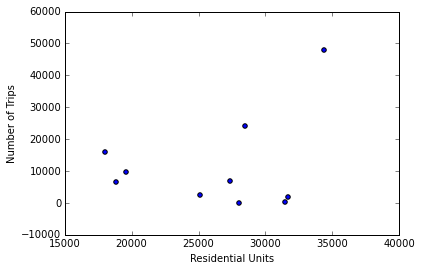

In [41]:
# Clean the nan value data 
df_bk_notnan = mynewdf_bk.dropna(axis=0)
# Test scatterplot
df_bk_notnan.plot(kind='scatter',x='Residential Units',y='Number of Trips')

In [42]:
X_bk = df_bk_notnan['Residential Units']
Y_bk = df_bk_notnan['Number of Trips']

2.37478208616 16979.3905512


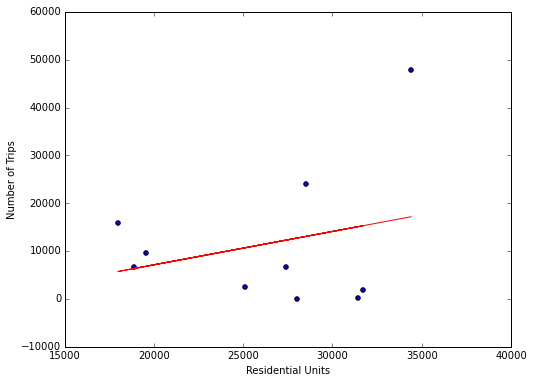

In [46]:
# Line fit for Brooklyn
model1_bk = sm.OLS(Y_bk, sm.add_constant(X_bk)).fit()  
print model1_v2.params[1], model1_v2.params[0]
pl.figure(figsize=(8, 6))
pl.scatter(X_bk,Y_bk)
pl.xlabel('Residential Units')
pl.ylabel('Number of Trips')
pl.plot(X_bk,X_bk*model1_bk.params[1]+model1_bk.params[0],color='red')
pl.legend()

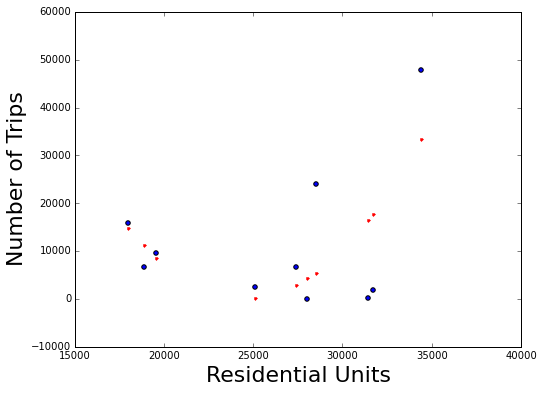

In [44]:
# 2 degree linear fit after removing the leverage points
model2_bk = smf.ols(formula = "y ~ x + I((x)) + I((x)**2) ", 
        data={'x':X_bk,'y': Y_bk}).fit()
pl.figure(figsize=(8, 6))
pl.scatter(X_bk, Y_bk)
pl.xlabel("Residential Units", fontsize=22)
pl.ylabel("Number of Trips", fontsize=22)
plot(X_bk,model2_bk.predict(),'k.',c='r')

In [45]:
Likelihood_1_bk = model1_bk.llf
Likelihood_2_bk = model2_bk.llf
lr_bk = -2*(Likelihood_1_bk - Likelihood_2_bk)
print lr_bk

4.86773939436


## Test Result
The lr result is 4.8677 which is higher than the critical value 3.84 which is for chi2 with 1 degree of freedom at the siginificance level of 0.05).This rejects the null hypothesis. Therefore, the 2 degree model fits better than the 1 degree model for Brooklyn. This contrasts with Manhattan.